In [4]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import gc

import string

from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier

from sklearn.multioutput import MultiOutputClassifier

import pickle

import seaborn as sns

from collections import Counter

from sklearn.metrics import fbeta_score

from sklearn.metrics import hamming_loss

from sklearn.metrics import jaccard_score

from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline

In [5]:
## store the embeddings and one hot encodings using np.save()

In [6]:
X_train,y_train,X_test,y_test = np.load('/kaggle/input/dal-data/embed_train.npy'),np.load('/kaggle/input/dal-data/labels_train.npy'),np.load('/kaggle/input/dal-data/embed_test.npy'),np.load('/kaggle/input/dal-data/labels_test.npy')

In [7]:
X_train = np.vstack((X_train,X_test))

y_train = np.vstack((y_train,y_test))

In [8]:
alphabets = list(string.ascii_uppercase)

In [9]:
# store both the multi label binarizer models

In [10]:
with open('/kaggle/input/dal-data/mlb.pkl','rb') as file:

    mlb = pickle.load(file)

with open('/kaggle/input/dal-data/mlb_letter.pkl','rb') as file:

    mlb_letter = pickle.load(file)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 1.5.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
#y_train_letter

y_labels_train = mlb.inverse_transform(y_train)

y_labels_test = mlb.inverse_transform(y_test)

In [12]:
y_starter_train = [tuple(s[0] for s in tup) for tup in y_labels_train]

y_starter_test = [tuple(s[0] for s in tup) for tup in y_labels_test]

In [13]:
y_train_letter = mlb_letter.transform(y_starter_train)

y_test_letter = mlb_letter.transform(y_starter_test)

In [14]:
gc.collect()

0

In [15]:
# find the number of labels in each label

final_length = np.sum(y_train,axis = 1)   #captures number of final labels assigned to each instance



letter_length = np.sum(y_train_letter,axis = 1) # captures number of letters assigned to each instance



print(Counter(final_length))



print(Counter(letter_length))

Counter({1: 17151, 2: 10874, 3: 5533, 4: 2843, 5: 1446, 6: 743, 7: 345, 8: 158, 9: 79, 10: 39, 11: 22, 12: 12, 14: 6, 13: 4, 16: 2, 15: 1})
Counter({1: 25959, 2: 10335, 3: 2572, 4: 349, 5: 39, 6: 4})


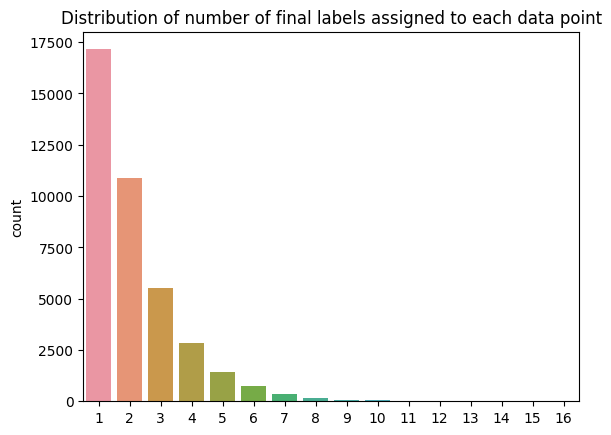

In [16]:
sns.countplot(x = final_length)

plt.title('Distribution of number of final labels assigned to each data point')

plt.show()

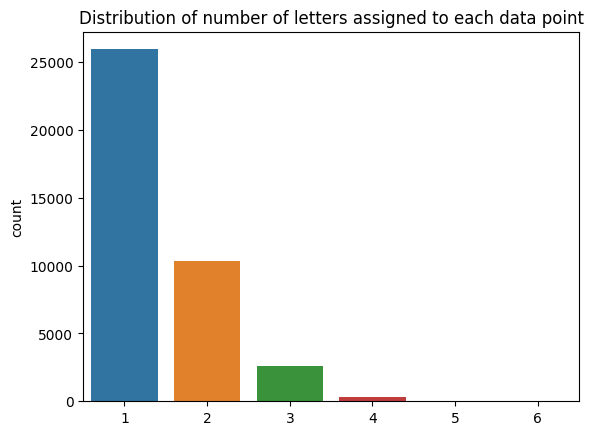

In [17]:
sns.countplot(x = letter_length)

plt.title('Distribution of number of letters assigned to each data point')

plt.show()

Conclusion is that you can go for clusters with 3 representatives to figure out most of the data

In [18]:
# Clustering on label_space

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(y_train_letter)



means = kmeans.cluster_centers_



# iterating through the observed means and making top 3 values 1 and the rest 0. Btw means cannot exceed 1

for i,mean in enumerate(means):

    indices = np.argsort(mean)[-4:]

    means[i,indices] = 1 



means[np.where(means!=1)] = 0



means_map = dict([(ind,mean) for ind,mean in enumerate(means)])  #map which maps the one hot encoding of the mean representatives to its cluster index

In [19]:
clusters = Counter(mlb_letter.inverse_transform(means)).keys()

print(clusters)

print(len(set(clusters)))

dict_keys([('D', 'K', 'Z'), ('G', 'J', 'R'), ('H', 'L', 'Z'), ('E', 'H', 'T'), ('E', 'N', 'R'), ('I', 'K', 'R'), ('E', 'L', 'N'), ('D', 'K', 'R'), ('G', 'M', 'S'), ('C', 'D', 'H'), ('E', 'J', 'M'), ('M', 'S', 'Z'), ('G', 'H', 'J'), ('K', 'Q', 'R'), ('K', 'R', 'Z'), ('D', 'L', 'N'), ('J', 'K', 'T'), ('L', 'N', 'Z'), ('F', 'K', 'Q'), ('K', 'N', 'R')])
20


In [20]:
y_train_cluster = np.array([means_map[ind] for ind in kmeans.predict(y_train_letter)]) #assigning representatives

In [21]:
mlabels = mlb.classes_



letter_presence = np.zeros_like(y_train_letter) 

#for any instance if value is 1, that means the data point has atleast one final label starting with this letter



i = 0

for letter in alphabets:

    if letter == 'P' or letter == 'U':

        continue

    #getting all indices of labels starting with 'letter'

    indices = [ind for ind,s in enumerate(mlabels) if s.startswith(letter)] 

    letter_presence[:,i] = np.any(y_train[:,indices],axis = 1)

    i +=1

In [22]:
true_predn = letter_presence*y_train_cluster 

#true when a letter is part of the representatives of the assigned cluster and has atleast one final label associated with the data point

In [23]:
#assuming stage 2 discards the useless labels and predicts the correct final labels (their count is discarded here but including 

#them will only increase the score

print(f"Score is {fbeta_score(true_predn,letter_presence,beta = 2,average = 'micro')}")

print(f"Hamming accuracy is {1-hamming_loss(true_predn,letter_presence)}")

print(f"Jaccard Accuracy: {jaccard_score(true_predn,letter_presence,average = 'samples')}")

Score is 0.987456461686284
Hamming accuracy is 0.9964529522645066
Jaccard Accuracy: 0.9606606721347667


In [24]:
y_labels_train[:10]

[('G89.29', 'M25.562'),
 ('K20.90', 'K25.9', 'K29.80', 'K31.89', 'R13.10'),
 ('K20.90', 'K57.30', 'R10.11', 'Z86.010', 'Z90.49'),
 ('K29.50', 'K31.89', 'R10.84', 'R19.7', 'R93.3'),
 ('K62.5', 'K64.5', 'K64.8'),
 ('H25.11', 'H53.8'),
 ('K57.30', 'K64.1', 'Z12.11'),
 ('S52.572A',),
 ('K62.1', 'K63.5', 'Z12.11', 'Z80.0', 'Z86.010'),
 ('D17.1', 'D17.22')]

In [25]:
mlb_letter.inverse_transform(y_train_cluster)[:10]

[('G', 'M', 'S'),
 ('I', 'K', 'R'),
 ('K', 'R', 'Z'),
 ('I', 'K', 'R'),
 ('D', 'K', 'Z'),
 ('H', 'L', 'Z'),
 ('D', 'K', 'Z'),
 ('G', 'M', 'S'),
 ('D', 'K', 'Z'),
 ('D', 'K', 'Z')]

In [26]:
# I need 2 plots, how many letters I correctly identify for each letter, how much percent of a multilabel I am doing well

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


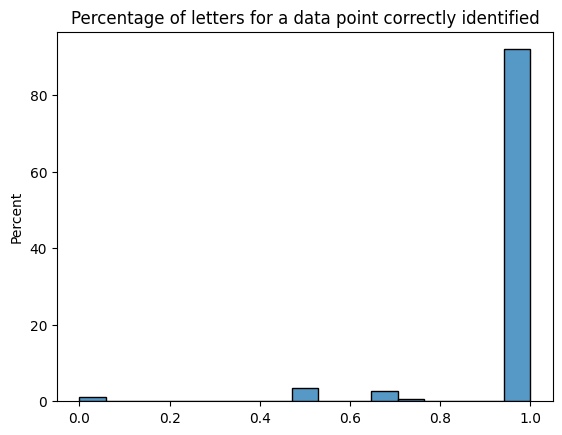

In [27]:
plt.figure(1)

sns.histplot(x  = np.sum((y_train_letter ==  y_train_cluster)*(y_train_letter == 1), axis = 1)/np.sum(y_train_letter,axis =1), stat = 'percent')

plt.title('Percentage of letters for a data point correctly identified')

plt.show()

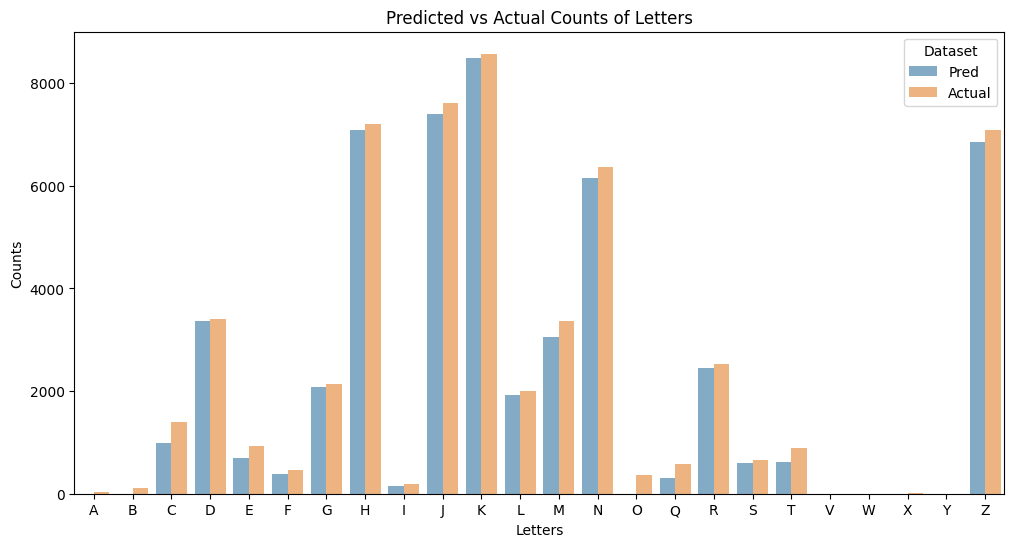

In [28]:
#carries the same assumption about the second stage

letter_pred = np.sum((y_train_letter == y_train_cluster)*(y_train_letter == 1),axis = 0)

letter_true = np.sum(y_train_letter,axis = 0)

data = {

    'Letter': [letter for letter in alphabets if letter!='P' and letter!='U'] * 2,

    'Count': np.concatenate([letter_pred, letter_true]),

    'Type': ['Pred'] * 24 + ['Actual'] * 24

}



# Create a DataFrame

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

sns.barplot(data=df, x='Letter', y='Count', hue='Type', alpha=0.6)



# Customize the plot

plt.xlabel("Letters")

plt.ylabel("Counts")

plt.title("Predicted vs Actual Counts of Letters")

plt.legend(title="Dataset")

# plt.xticks(ticks = plt.xticks()[0],labels = [letter for letter in alphabets if letter != 'P' or letter!='U'])

# plt.legend(['Pred','Actual'])

In [29]:
## setting up the multiclass problem

In [30]:
from sklearn.preprocessing import OneHotEncoder



cluster_enc = OneHotEncoder(sparse_output = False)

y_cluster_train = cluster_enc.fit_transform(kmeans.predict(y_train_letter).reshape(-1,1))

In [31]:
## train a multiclass classifier

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 42, verbose = 2)

classifier.fit(X_train, y_cluster_train)

building tree 1 of 15
building tree 2 of 15
building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


RandomForestClassifier(criterion='entropy', n_estimators=15, random_state=42,
                       verbose=2)

In [32]:
n_test = 10000

In [33]:
y_cluster_onehot = classifier.predict(X_test[:n_test])



y_cluster_no = np.argmax(y_cluster_onehot,axis = 1)



y_cluster_rep = np.array([means_map[ind] for ind in y_cluster_no])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


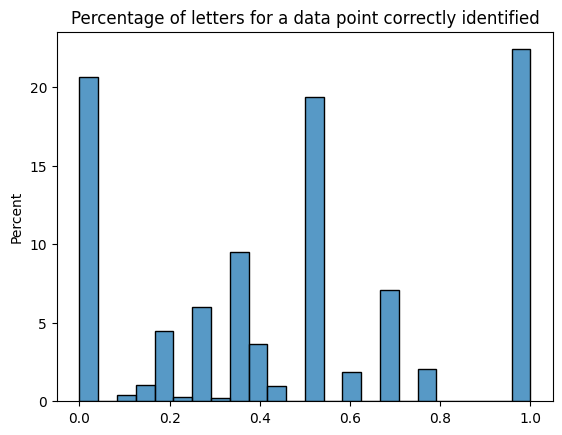

In [34]:
plt.figure(1)

plt.title('Percentage of letters for a data point correctly identified')

sns.histplot(x  = np.sum((y_test_letter[:n_test] ==  y_cluster_rep)*(y_test_letter[:n_test] == 1), axis = 1)/np.sum(y_test[:n_test],axis =1), stat = 'percent')

plt.show()

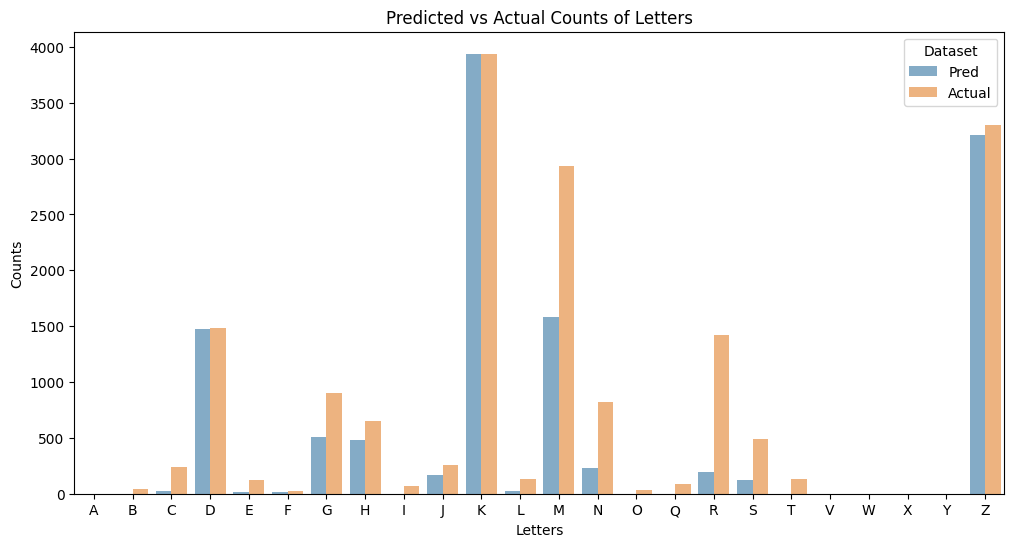

In [35]:
letter_pred = np.sum((y_test_letter[:n_test] ==  y_cluster_rep)*(y_test_letter[:n_test] == 1),axis = 0)

letter_true = np.sum(y_test_letter[:n_test],axis = 0)

data = {

    'Letter': [letter for letter in alphabets if letter!='P' and letter!='U'] * 2,

    'Count': np.concatenate([letter_pred, letter_true]),

    'Type': ['Pred'] * 24 + ['Actual'] * 24

}



# Create a DataFrame

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

sns.barplot(data=df, x='Letter', y='Count', hue='Type', alpha=0.6)



# Customize the plot

plt.xlabel("Letters")

plt.ylabel("Counts")

plt.title("Predicted vs Actual Counts of Letters")

plt.legend(title="Dataset")

In [36]:
letter_presence_test = np.zeros_like(y_cluster_rep)

i = 0

for letter in alphabets:

    if letter == 'P' or letter == 'U':

        continue

    indices = [ind for ind,s in enumerate(mlabels) if s.startswith(letter)] 

    letter_presence_test[:,i] = np.any(y_test[:n_test,indices],axis = 1)

    i +=1

In [37]:
true_predn_test = letter_presence_test*y_cluster_rep

In [38]:
print(f"Score is {fbeta_score(true_predn_test,letter_presence_test,beta = 2,average = 'micro')}")

print(f"Hamming accuracy is {1-hamming_loss(true_predn_test,letter_presence_test)}")

print(f"Jaccard Accuracy: {jaccard_score(true_predn_test,letter_presence_test,average = 'samples')}")

Score is 0.9214046308539098
Hamming accuracy is 0.9787
Jaccard Accuracy: 0.7037550000000001


In [39]:
import tensorflow as tf
from tensorflow.keras import backend as K
def micro_f2(y_true, y_pred):
    y_true = K.cast(y_true, tf.float32)
    y_pred = K.cast(y_pred > 0.5, tf.float32)  # Threshold to get binary predictions
    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)
    predicted_positives = K.sum(y_pred)
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f2 = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall + K.epsilon())
    return f2

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def build_model(input_dim, output_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(output_dim, activation='sigmoid')  # Output layer for multi-label
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=[micro_f2])
    return model



In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_cnn_model(input_dim, output_dim):
    inputs = Input(shape=(input_dim, 1))

    # Define Conv1D layers with different kernel sizes
    convs = []
    for kernel_size in [2, 3, 4, 5]:
        conv = Conv1D(filters=100, kernel_size=kernel_size, activation='relu')(inputs)
        pool = GlobalMaxPooling1D()(conv)
        convs.append(pool)
    
    # Concatenate pooled features from each Conv1D layer
    merged = Concatenate()(convs)

    # Dropout layer with 0.8 dropout rate
    x = Dropout(0.8)(merged)

    # Dense layer with sigmoid activation for binary multi-label output
    outputs = Dense(output_dim, activation='sigmoid')(x)

    # Build and compile the model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[micro_f2])
    
    return model

In [48]:
### 10 models for final predn

models ={}

indices_map = {}

labels_map = {} #key is cluster

for i,mean in tqdm(enumerate(means)):

    letters = mlb_letter.inverse_transform(mean.reshape(1,-1))[0]

    indices = [ind for ind,s in enumerate(mlabels) if s.startswith(letters)] 

    indices_map[i] = indices

    labels = [s for ind,s in enumerate(mlabels) if s.startswith(letters)] 

    labels_map[i] = labels

    train_data = X_train

    train_labels = y_train[:,indices]



    necessary_indices = np.sum(train_labels,axis = 1) !=0  #ranges from 5000-10000

    necessary_train_data = train_data[necessary_indices,:]

    necessary_train_labels = train_labels[necessary_indices,:]

    # print(f"Cluster {i} has {np.sum(necessary_indices)} data points")

    model = build_model(train_data.shape[1],len(indices))

    model.fit(necessary_train_data,necessary_train_labels, epochs = 20, batch_size = 64)

    models[i] = model

0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1282 - micro_f2: 0.1680
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - micro_f2: 0.5904
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - micro_f2: 0.7243
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - micro_f2: 0.7737
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - micro_f2: 0.8125
Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - micro_f2: 0.8344
Epoch 7/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - micro_f2: 0.8515
Epoch 8/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - micro_f2: 0.8690
Epoch 9/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - micro_f2: 0.8838
Epoch 10/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - micro_f2: 0.8980
Epoch 11/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - micro_f2: 0.9104
Epoch 12/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

1it [00:11, 11.05s/it]

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1545 - micro_f2: 0.3643
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - micro_f2: 0.7625
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - micro_f2: 0.8227
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0101 - micro_f2: 0.8478
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090 - micro_f2: 0.8618
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - micro_f2: 0.8731
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077 - micro_f2: 0.8810
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - micro_f2: 0.8970
Epoch 9/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - micro_f2: 0.9076
Epoch 10/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - micro_f2: 0.9099
Epoch 11/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - micro_f2: 0.9169
Epoch 12/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2it [00:19,  9.45s/it]

Epoch 1/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1228 - micro_f2: 0.1616
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0085 - micro_f2: 0.5714
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058 - micro_f2: 0.6781
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - micro_f2: 0.7248
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - micro_f2: 0.7544
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - micro_f2: 0.7778
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - micro_f2: 0.8021
Epoch 8/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - micro_f2: 0.8178
Epoch 9/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - micro_f2: 0.8280
Epoch 10/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - micro_f2: 0.8486
Epoch 11/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - micro_f2: 0.8551
Epoch 12/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

3it [00:31, 10.48s/it]

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1837 - micro_f2: 0.0699
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - micro_f2: 0.4348
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0096 - micro_f2: 0.5835
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077 - micro_f2: 0.6624
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - micro_f2: 0.7065
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - micro_f2: 0.7318
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - micro_f2: 0.7549
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - micro_f2: 0.7724
Epoch 9/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - micro_f2: 0.7952
Epoch 10/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - micro_f2: 0.8024
Epoch 11/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - micro_f2: 0.8201
Epoch 12/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

4it [00:38,  9.40s/it]

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1678 - micro_f2: 0.1247
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - micro_f2: 0.5538
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097 - micro_f2: 0.6988
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080 - micro_f2: 0.7634
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - micro_f2: 0.8021
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - micro_f2: 0.8286
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - micro_f2: 0.8482
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - micro_f2: 0.8629
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - micro_f2: 0.8793
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - micro_f2: 0.8908
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - micro_f2: 0.9047
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

5it [00:47,  9.14s/it]

Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1587 - micro_f2: 0.1538
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0164 - micro_f2: 0.5578
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0111 - micro_f2: 0.7010
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088 - micro_f2: 0.7688
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - micro_f2: 0.8115
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0065 - micro_f2: 0.8343
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - micro_f2: 0.8559
Epoch 8/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - micro_f2: 0.8751
Epoch 9/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - micro_f2: 0.8941
Epoch 10/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - micro_f2: 0.9099
Epoch 11/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - micro_f2: 0.9265
Epoch 12/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

6it [00:55,  8.84s/it]

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1720 - micro_f2: 0.1245
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0158 - micro_f2: 0.5503
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - micro_f2: 0.6815
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0096 - micro_f2: 0.7323
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084 - micro_f2: 0.7755
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - micro_f2: 0.7966
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066 - micro_f2: 0.8222
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - micro_f2: 0.8389
Epoch 9/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - micro_f2: 0.8555
Epoch 10/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - micro_f2: 0.8745
Epoch 11/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - micro_f2: 0.8830
Epoch 12/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

7it [01:03,  8.37s/it]

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1475 - micro_f2: 0.1131
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - micro_f2: 0.5202
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - micro_f2: 0.6788
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080 - micro_f2: 0.7401
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - micro_f2: 0.7888
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - micro_f2: 0.8160
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - micro_f2: 0.8348
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - micro_f2: 0.8560
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - micro_f2: 0.8725
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - micro_f2: 0.8903
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - micro_f2: 0.9027
Epoch 12/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

8it [01:13,  8.89s/it]

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2333 - micro_f2: 0.0338
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - micro_f2: 0.3056
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089 - micro_f2: 0.5131
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0067 - micro_f2: 0.6239
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - micro_f2: 0.7062
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0044 - micro_f2: 0.7457
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 - micro_f2: 0.7830
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 - micro_f2: 0.8114
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - micro_f2: 0.8252
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - micro_f2: 0.8571
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 - micro_f2: 0.8726
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - micro

9it [01:19,  7.97s/it]

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1415 - micro_f2: 0.0584
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - micro_f2: 0.4415
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - micro_f2: 0.6272
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - micro_f2: 0.6961
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 - micro_f2: 0.7359
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - micro_f2: 0.7680
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - micro_f2: 0.7879
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - micro_f2: 0.8059
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - micro_f2: 0.8216
Epoch 10/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - micro_f2: 0.8343
Epoch 11/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - micro_f2: 0.8480
Epoch 12/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

10it [01:28,  8.34s/it]

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1352 - micro_f2: 0.2260
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - micro_f2: 0.6644
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - micro_f2: 0.7534
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042 - micro_f2: 0.7981
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - micro_f2: 0.8211
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - micro_f2: 0.8413
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - micro_f2: 0.8557
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - micro_f2: 0.8675
Epoch 9/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - micro_f2: 0.8763
Epoch 10/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - micro_f2: 0.8901
Epoch 11/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - micro_f2: 0.8967
Epoch 12/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

11it [01:37,  8.74s/it]

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1497 - micro_f2: 0.1224
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077 - micro_f2: 0.5077
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - micro_f2: 0.6411
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039 - micro_f2: 0.7238
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - micro_f2: 0.7648
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - micro_f2: 0.8069
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - micro_f2: 0.8255
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - micro_f2: 0.8482
Epoch 9/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - micro_f2: 0.8668
Epoch 10/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - micro_f2: 0.8844
Epoch 11/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - micro_f2: 0.8971
Epoch 12/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

12it [01:46,  8.69s/it]

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1351 - micro_f2: 0.2212
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0100 - micro_f2: 0.6568
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - micro_f2: 0.7395
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064 - micro_f2: 0.7783
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058 - micro_f2: 0.7971
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - micro_f2: 0.8136
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - micro_f2: 0.8265
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - micro_f2: 0.8429
Epoch 9/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - micro_f2: 0.8503
Epoch 10/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - micro_f2: 0.8584
Epoch 11/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - micro_f2: 0.8686
Epoch 12/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

13it [01:56,  9.20s/it]

Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1615 - micro_f2: 0.1312
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0158 - micro_f2: 0.5390
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0106 - micro_f2: 0.6892
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - micro_f2: 0.7659
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - micro_f2: 0.7966
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - micro_f2: 0.8303
Epoch 7/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - micro_f2: 0.8568
Epoch 8/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - micro_f2: 0.8754
Epoch 9/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - micro_f2: 0.8865
Epoch 10/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - micro_f2: 0.9037
Epoch 11/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - micro_f2: 0.9170
Epoch 12/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

14it [02:05,  9.11s/it]

Epoch 1/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1252 - micro_f2: 0.1943
Epoch 2/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - micro_f2: 0.6250
Epoch 3/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080 - micro_f2: 0.7323
Epoch 4/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065 - micro_f2: 0.7864
Epoch 5/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - micro_f2: 0.8116
Epoch 6/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - micro_f2: 0.8426
Epoch 7/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - micro_f2: 0.8599
Epoch 8/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0038 - micro_f2: 0.8819
Epoch 9/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - micro_f2: 0.8954
Epoch 10/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - micro_f2: 0.9071
Epoch 11/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - micro_f2: 0.9175
Epoch 12/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

15it [02:17, 10.01s/it]

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1569 - micro_f2: 0.0944
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - micro_f2: 0.5348
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - micro_f2: 0.6740
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078 - micro_f2: 0.7303
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - micro_f2: 0.7607
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061 - micro_f2: 0.7912
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - micro_f2: 0.8107
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - micro_f2: 0.8266
Epoch 9/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - micro_f2: 0.8497
Epoch 10/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - micro_f2: 0.8616
Epoch 11/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - micro_f2: 0.8804
Epoch 12/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

16it [02:26,  9.62s/it]

Epoch 1/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1179 - micro_f2: 0.2949
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - micro_f2: 0.7121
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088 - micro_f2: 0.7850
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0074 - micro_f2: 0.8227
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066 - micro_f2: 0.8445
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - micro_f2: 0.8631
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - micro_f2: 0.8772
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - micro_f2: 0.8906
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - micro_f2: 0.8999
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - micro_f2: 0.9106
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - micro_f2: 0.9178
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

17it [02:38, 10.20s/it]

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1396 - micro_f2: 0.1833
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - micro_f2: 0.6090
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - micro_f2: 0.7211
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - micro_f2: 0.7657
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - micro_f2: 0.7912
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054 - micro_f2: 0.8153
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - micro_f2: 0.8305
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - micro_f2: 0.8467
Epoch 9/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - micro_f2: 0.8622
Epoch 10/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - micro_f2: 0.8791
Epoch 11/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - micro_f2: 0.8919
Epoch 12/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

18it [02:48, 10.15s/it]

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1740 - micro_f2: 0.1717
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0180 - micro_f2: 0.5816
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123 - micro_f2: 0.7284
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0098 - micro_f2: 0.7825
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0085 - micro_f2: 0.8189
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - micro_f2: 0.8435
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063 - micro_f2: 0.8638
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - micro_f2: 0.8824
Epoch 9/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - micro_f2: 0.8976
Epoch 10/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - micro_f2: 0.9074
Epoch 11/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - micro_f2: 0.9281
Epoch 12/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

19it [02:55,  9.37s/it]

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1253 - micro_f2: 0.1351
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103 - micro_f2: 0.5867
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - micro_f2: 0.7139
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061 - micro_f2: 0.7621
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - micro_f2: 0.7934
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - micro_f2: 0.8248
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - micro_f2: 0.8459
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - micro_f2: 0.8656
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - micro_f2: 0.8779
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - micro_f2: 0.8980
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - micro_f2: 0.9063
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

20it [03:06,  9.35s/it]


In [49]:
def final_pred(X_test,pred_1,means,mlabels,models):

    pred_2 = np.zeros((X_test.shape[0],len(mlabels)))

    #pred_1 is y_cluster_no

    for i,mean in enumerate(means):

        letters = mlb_letter.inverse_transform(mean.reshape(1,-1))[0]

        indices = (pred_1 == i)

        if(np.sum(indices) ==0):

            continue

        test_data = X_test[indices,:]

        model_predn = np.zeros((np.sum(indices),len(mlabels)))

        model_predn[:,indices_map[i]] = models[i].predict(test_data) > 0.5

        pred_2[indices,:] = model_predn

    return pred_2

In [50]:
indices = np.arange(len(X_test))

np.random.shuffle(indices)

subsets_indices = np.array_split(indices, 10)

In [51]:
gc.collect()

2030

In [52]:
scores = []

for sub in tqdm(subsets_indices[:5]):

    X_sub = X_test[sub]

    y_sub = y_test[sub]



    

    y_cluster_onehot_sub = classifier.predict(X_sub)

    y_cluster_no_sub = np.argmax(y_cluster_onehot_sub,axis = 1)

    

    pred_2 = final_pred(X_sub,y_cluster_no_sub,means,mlabels,models)

    scores.append(fbeta_score(pred_2,y_sub,beta = 2,average = 'micro'))



    del X_sub,y_sub,y_cluster_onehot_sub,y_cluster_no_sub

    gc.collect()

print(scores)

print(np.mean(scores))

  0%|          | 0/5 [00:00<?, ?it/s]

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 20%|██        | 1/5 [00:12<00:50, 12.73s/it]

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|████      | 2/5 [00:22<00:33, 11.12s/it]

271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 3/5 [00:32<00:20, 10.50s/it]

272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 4/5 [00:42<00:10, 10.21s/it]

269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 5/5 [00:51<00:00, 10.37s/it]

[0.7426980247606075, 0.7476336146836011, 0.7449015275547997, 0.752645586464736, 0.7528149665697905]
0.7481387440067071


In [53]:
real_test = np.load('/kaggle/input/dal-test/test_data.npy')

In [54]:
real_X_sub = real_test



y_cluster_onehot_sub = classifier.predict(real_X_sub)

y_cluster_no_sub = np.argmax(y_cluster_onehot_sub,axis = 1)



pred_2 = mlb.inverse_transform(final_pred(real_X_sub,y_cluster_no_sub,means,mlabels,models))

2879/2879 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


In [55]:
empty_pred = [i for i,pred in enumerate(pred_2) if pred == ()]

In [56]:
len(empty_pred)

35110

In [57]:
import csv

filename = "output_7.csv"



# Write the list of tuples to the CSV file

with open(filename, mode='w', newline='') as file:

    writer = csv.writer(file)

    # Write the header

    writer.writerow(["id", "labels"])

    

    # Write each row with sequential ID

    for idx, labels in enumerate(pred_2, start=1):

        # Join labels with ';' and write to file

        writer.writerow([idx, ";".join(labels)])



print(f"Data saved to {filename}")

Data saved to output_6.csv


In [46]:
final_pred

<function __main__.final_pred(X_test, pred_1, means, mlabels, models)>

In [47]:
gc.collect()

378

In [48]:
pred_2 = final_pred(X_test[:n_test],y_cluster_no,means,mlabels,models)

In [49]:
print(f"Score is {fbeta_score(pred_2,y_test[:n_test],beta = 2,average = 'micro')}")

Score is 0.9505074782235966


In [50]:
### A few comparisons ###

In [51]:
mlb.inverse_transform(pred_2[:5])

[('H65.06', 'H65.23', 'H65.33', 'H69.83'),
 ('D12.2', 'K57.30', 'K62.1', 'Z12.11', 'Z86.010'),
 ('M25.551', 'M25.561', 'M47.816', 'M48.061', 'M51.16', 'M54.50', 'M79.651'),
 ('K21.00', 'K22.70', 'K31.89', 'Z87.19'),
 ('N84.1', 'N93.8', 'N93.9')]

In [52]:
y_labels_test[:5]

[('H65.06', 'H65.23', 'H65.33', 'H69.83'),
 ('D12.2', 'D12.4', 'K57.30', 'K62.1', 'Z12.11', 'Z86.010'),
 ('M25.551', 'M25.561', 'M47.816', 'M48.061', 'M51.16', 'M54.50', 'M79.651'),
 ('K21.00', 'K22.70', 'K29.50', 'K31.89'),
 ('N84.1', 'N93.8', 'N93.9', 'Z30.430')]

In [53]:
# means[np.where((means>=0.1) * (means<=1.00))[0],np.where((means>=0.1) * (means<=1.00))[1]] = 1

# means[np.where(means!=1)] = 0